### Solve Gearbox Ratios

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.transforms import Affine2D
import time
from matplotlib.offsetbox import AnchoredText 
import mplcursors 
import os
import json
from gearbox import Gearbox

from tqdm import tqdm

In [2]:
config = {
  "MODULE": 0.8e-3,
  "MC": 0.8467e-3,
  "MU": 0.21,
  "ALPHA": 20,
  "XS": 0.476,
  "XP1": 0.762,
  "XP2": 0.536,
  "XR1": 2,
  "XR2": 1.21,
  "XS_RANGE": [-0.5, 0.5, 0.25],
  "XP1_RANGE": [-1, 1, 0.25],
  "XP2_RANGE": [-0.5, 0.5, 0.25],
  "XR2_RANGE": [-1.5, 1.5, 0.25],
  "N_PLANETS": 3,
  "SUN_LIMITS": [4, 30],
  "P1_LIMITS": [20, 42],
  "P2_LIMITS": [20, 40],
  "R2_LIMITS": [60, 90],
  "STEPS": [2, 1, 1, 1],
  "MIN_RATIO_THRESHOLD": 90,
  "MIN_FORWARD_THRESHOLD": 0.30,
  "MIN_BACKWARD_THRESHOLD": 0.30
}


In [3]:
MODULE = config["MODULE"]
MU = config["MU"]
MC = config.get("MC", MODULE)
ALPHA = np.radians(config.get("ALPHA", 20))
XR1 = config.get("XR1", 0.0)
N_PLANETS = config["N_PLANETS"]
SUN_LIMITS = tuple(config["SUN_LIMITS"])
P1_LIMITS  = tuple(config["P1_LIMITS"])
P2_LIMITS  = tuple(config["P2_LIMITS"])
R2_LIMITS  = tuple(config["R2_LIMITS"])
STEPS = tuple(config["STEPS"])
MIN_RATIO_THRESHOLD = config["MIN_RATIO_THRESHOLD"]
MIN_FORWARD_THRESHOLD = config["MIN_FORWARD_THRESHOLD"]
MIN_BACKWARD_THRESHOLD = config["MIN_BACKWARD_THRESHOLD"]

SLICE_GEAR_RATIO = True 
TARGET_GEAR_RATIO = 100
RATIO_TOLERANCE = 10
DISPLAY_BEST_GEARBOX = False
DISPLAY_ITERATIONS_PLOT = True
RUN_SAMPLE_TRIAL = False
MAX_CANDIDATES = 1000

In [4]:
def generate_options(lower: int, upper: int, step: int = 1):
    return list(range(lower, upper + 1, step))

def generate_range_options(range_vals):
    low, high, step = range_vals
    opts = []
    current = low
    while current <= high + 1e-9:
        opts.append(round(current, 5))
        current += step
    return opts

def generate_all_options(sun_limits: tuple, p1_limits: tuple, p2_limits: tuple, r2_limits: tuple, 
                         steps: tuple = (1,1,1,1)):
    step_sun, step_p1, step_p2, step_r2 = steps
    return {
        "sun": generate_options(sun_limits[0], sun_limits[1], step_sun),
        "p1": generate_options(p1_limits[0], p1_limits[1], step_p1),
        "p2": generate_options(p2_limits[0], p2_limits[1], step_p2),
        "r2": generate_options(r2_limits[0], r2_limits[1], step_r2)
    }

In [5]:
options = generate_all_options(SUN_LIMITS, P1_LIMITS, P2_LIMITS, R2_LIMITS, STEPS)
sun_options = options["sun"]
p1_options  = options["p1"]
p2_options  = options["p2"]
r2_options  = options["r2"]
xs_options = generate_range_options(config["XS_RANGE"])
xp1_options = generate_range_options(config["XP1_RANGE"])
xp2_options = generate_range_options(config["XP2_RANGE"])
xr2_options = generate_range_options(config["XR2_RANGE"])

In [6]:
def view_vector(input_vector, subsample, title, y_lims=None):
    fig, ax = plt.subplots()
    to_plot = input_vector[::subsample]
    xs = np.arange(len(to_plot))
    ax.scatter(xs, to_plot)
    ax.set_title(title)
    if y_lims:
        ax.set_ylim(y_lims)
    plt.show()

/tmp/ipykernel_29723/886025024.py:21: RuntimeWarning: divide by zero encountered in divide
  ratios = 1 / gr_s


/tmp/ipykernel_29723/886025024.py:48: RuntimeWarning: divide by zero encountered in divide
  ratios = 1 / gr_s


Of 321805575 total inputs, there are 523575 valid combinations
Efficiency shapes: (523575,), (523575,)
Average Forward Efficiency: 0.3048 +/- 0.1946
Average Backward Efficiency: 0.0789 +/- 0.1829


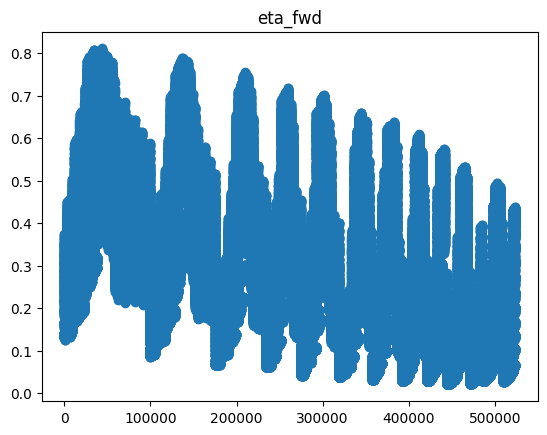

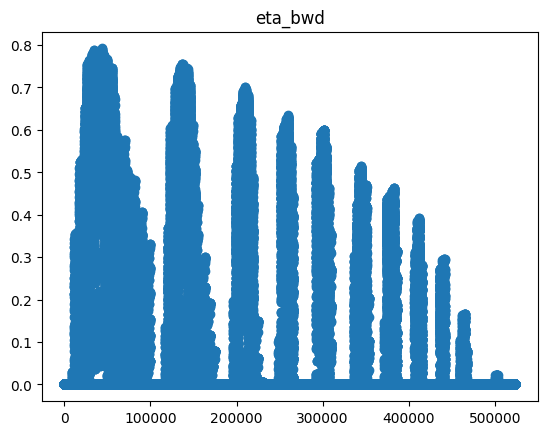

z_p1 vals: [33 34 35 36 37 38 39 40 41 42]
z_s vals: [ 6  8 10 12 14 16 18 20 22 24]
z_p2 vals: [25 26 27 28 29 30 31 32 33 34 35]
z_r2 vals: [65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88
 89 90]


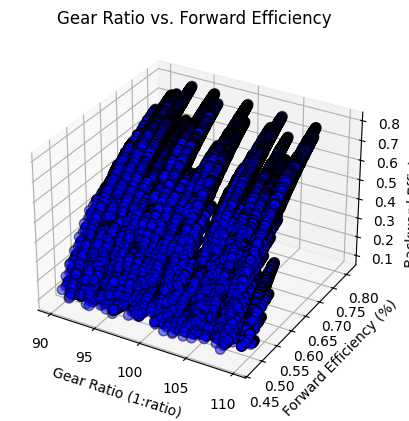

Parameters (z_s, z_p1, z_p2, z_r2, xs, xp1, xp2, xr2): [6], [42], [28 29 30 31], [71 72 73 74 75 76 78], [-0.5  -0.25  0.    0.25  0.5 ], [-0.75 -0.5  -0.25  0.    0.25  0.5   0.75  1.  ], [-0.5  -0.25  0.    0.25  0.5 ], [-0.75 -0.5  -0.25  0.    0.25  0.5   0.75  1.    1.25  1.5 ]


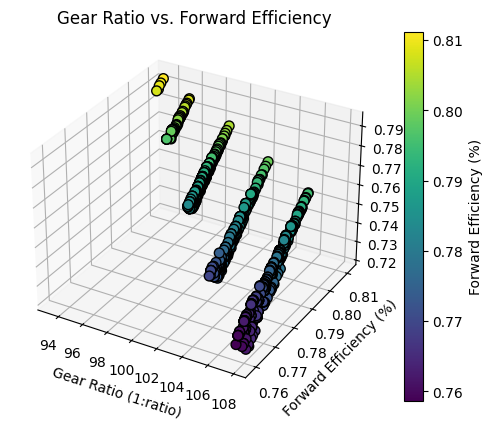

In [7]:
# Calculate z_r1 for each combination of z_s and z_p1
z_s, z_p1 = np.meshgrid(sun_options, p1_options, indexing='ij')
z_r1 = z_s + 2 * z_p1

target_z_r1 = 90

valid_indices = np.where(z_r1 == target_z_r1)
filtered_z_s = z_s[valid_indices]
filtered_z_p1 = z_p1[valid_indices]

# Calculate all possible combinations of gear ratios
z_s, z_p1, z_p2, z_r2 = np.meshgrid(
    filtered_z_s, filtered_z_p1, p2_options, r2_options, indexing='ij'
)

z_r1 = target_z_r1

I1 = z_r1 / z_s
I2 = (z_r1 * z_p2) / (z_p1 * z_r2)
gr_s = (1 - I2) / (1 + I1)
ratios = 1 / gr_s

# only keep valid combinations (ratios w.in tolerance)
valid_combinations = np.logical_and(gr_s > 0, np.abs(TARGET_GEAR_RATIO - ratios) <= RATIO_TOLERANCE)
filt_z_s = np.unique(z_s[valid_combinations])
filt_z_p1 = np.unique(z_p1[valid_combinations])
filt_z_p2 = np.unique(z_p2[valid_combinations])
filt_z_r2 = np.unique(z_r2[valid_combinations])


z_s, z_p1, z_p2, z_r2, xs, xp1, xp2, xr2 = np.meshgrid(
    filt_z_s, filt_z_p1, filt_z_p2, filt_z_r2, xs_options, xp1_options, xp2_options, xr2_options, indexing='ij'
)

# flatten
z_s = z_s.flatten()
z_p1 = z_p1.flatten()
z_p2 = z_p2.flatten()
z_r2 = z_r2.flatten()
xs = xs.flatten()
xp1 = xp1.flatten()
xp2 = xp2.flatten()
xr2 = xr2.flatten()

I1 = z_r1 / z_s
I2 = (z_r1 * z_p2) / (z_p1 * z_r2)
gr_s = (1 - I2) / (1 + I1)
ratios = 1 / gr_s

total_combinations = z_s.size

valid_combinations = np.logical_and(np.logical_and(gr_s > 0, np.abs(TARGET_GEAR_RATIO - ratios) <= RATIO_TOLERANCE), z_s + 2 * z_p1 == z_r1)

# z_r1 = z_r1[valid_combinations]
z_s, z_p1, z_p2, z_r2, xs, xp1, xp2, xr2 = z_s[valid_combinations], z_p1[valid_combinations], z_p2[valid_combinations], z_r2[valid_combinations], xs[valid_combinations], xp1[valid_combinations], xp2[valid_combinations], xr2[valid_combinations]
I1, I2, gr_s, ratios = I1[valid_combinations], I2[valid_combinations], gr_s[valid_combinations], ratios[valid_combinations]

assert z_s.shape == z_p1.shape == z_p2.shape == z_r2.shape == xs.shape == xp1.shape == xp2.shape == xr2.shape == ratios.shape

print(f'Of {total_combinations} total inputs, there are {len(z_s)} valid combinations')

ra = (z_s * MODULE + z_p1 * MODULE) / 2.0

# Basic circle diameters
db_a1 = MODULE * z_s * np.cos(ALPHA)
db_a2 = MODULE * z_p1 * np.cos(ALPHA)
db_b1 = MODULE * z_p1 * np.cos(ALPHA)
db_b2 = MODULE * target_z_r1 * np.cos(ALPHA)
db_c1 = MC * z_p2 * np.cos(ALPHA)
db_c2 = MC * z_r2 * np.cos(ALPHA)

# Working pressure angles (modified formula)
alpha_wa = np.arccos(MODULE * (z_s + z_p1) * np.cos(ALPHA) / (2 * ra))
alpha_wb = np.arccos(MODULE * (-z_p1 + target_z_r1) * np.cos(ALPHA) / (2 * ra)) # why is this constant??
val = MC * (-z_p2 + z_r2) * np.cos(ALPHA) / (2 * ra)
alpha_wc = np.arccos(np.clip(val, -1, 1))
# Center distance modification coefficient
ya = ((z_s + z_p1) / 2.0) * ((np.cos(ALPHA) / np.cos(alpha_wa)) - 1)
# Tip circle diameters
das  = MODULE * z_s + 2 * MODULE * (1 + ya - xp1)
dap1 = MODULE * z_p1 + 2 * MODULE * (1 + np.minimum(ya - xs, xp1))
dar1 = MODULE * target_z_r1 - 2 * MODULE * (1 - XR1)
dap2 = MC * z_p2 + 2 * MC * (1 + xp2)
dar2 = MC * z_r2 - 2 * MC * (1 - xr2)
# Tip pressure angles
alpha_aa1 = np.arccos(db_a1 / das)
alpha_aa2 = np.arccos(db_a2 / dap1)
alpha_ab1 = np.arccos(db_b1 / dap1)
alpha_ab2 = np.arccos(db_b2 / dar1)
alpha_ac1 = np.arccos(db_c1 / dap2)
val2 = db_c2 / dar2
alpha_ac2 = np.arccos(np.clip(val2, -1, 1))
# Approach and recess contact ratios
ea1 = (z_p1 / (2 * np.pi)) * (np.tan(alpha_aa2) - np.tan(alpha_wa))
ea2 = (z_s / (2 * np.pi)) * (np.tan(alpha_aa1) - np.tan(alpha_wa))
eb1 = -(target_z_r1 / (2 * np.pi)) * (np.tan(alpha_ab2) - np.tan(alpha_wb))
eb2 = (z_p1 / (2 * np.pi)) * (np.tan(alpha_ab1) - np.tan(alpha_wb))
ec1 = -(z_r2 / (2 * np.pi)) * (np.tan(alpha_ac2) - np.tan(alpha_wc))
ec2 = (z_p2 / (2 * np.pi)) * (np.tan(alpha_ac1) - np.tan(alpha_wc))
ea = ea1**2 + ea2**2 - ea1 - ea2 + 1
eb = eb1**2 + eb2**2 - eb1 - eb2 + 1
ec = ec1**2 + ec2**2 - ec1 - ec2 + 1
# Basic driving efficiencies
Ea_val = 1 - MU* np.pi * (1 / z_s + 1 / z_p1) * ea
Eb_val = 1 - MU* np.pi * (1 / z_p1 - 1 / target_z_r1) * eb
Ec_val = 1 - MU* np.pi * (1 / z_p2 - 1 / z_r2) * ec
# Forward driving efficiency 
eta_fwd = (1 + Ea_val * Eb_val * I1) * (1 - I2) / ((1 + I1) * (1 - Eb_val * Ec_val * I2))
# Backward driving efficiency
def eta_bwd1(I1, I2, Ea_val, Eb_val, Ec_val):
    return (1 + I1) * Ea_val * (Eb_val * Ec_val - I2) / (Ec_val * (Ea_val * Eb_val + I1) * (1 - I2))
def eta_bwd2(I1, I2, Ea_val, Eb_val, Ec_val):
    return (1 + I1)*Ea_val*(1-Eb_val*Ec_val*I2)/((Ea_val+Eb_val*I1)*(1-I2))
eta_bwd = np.where(I2 > 1, eta_bwd2(I1, I2, Ea_val, Eb_val, Ec_val), eta_bwd1(I1, I2, Ea_val, Eb_val, Ec_val))
# eta_bwd = (1 + I1) * Ea_val * (Eb_val * Ec_val - I2) / (Ec_val * (Ea_val * Eb_val + I1) * (1 - I2))

# filter high eta_bwd
eta_bwd = np.where(eta_bwd > 1, 0, eta_bwd)
eta_bwd = np.where(eta_bwd < 0, 0, eta_bwd)

# Average and std for eta
avg_fwd = np.mean(eta_fwd)
std_fwd = np.std(eta_fwd)
avg_bwd = np.mean(eta_bwd)
std_bwd = np.std(eta_bwd)
print(f'Efficiency shapes: {eta_fwd.shape}, {eta_bwd.shape}')
print(f"Average Forward Efficiency: {avg_fwd:.4f} +/- {std_fwd:.4f}")
print(f"Average Backward Efficiency: {avg_bwd:.4f} +/- {std_bwd:.4f}")

view_vector(eta_fwd, 1, "eta_fwd")
view_vector(eta_bwd, 1, "eta_bwd")

composite_score = ratios * eta_fwd * eta_bwd

# create a list of the n (Max_Candidates) best scores
# sort all vectors by composite score
sorted_indices = np.argsort(composite_score)[::-1]
# sorted_indices = np.argsort(eta_bwd)[::-1]
best_indices = sorted_indices[:MAX_CANDIDATES]

# make 'best' versions of all the arrays
best_z_s = z_s[best_indices]
best_z_p1 = z_p1[best_indices]
best_z_r1 = z_r1
best_z_p2 = z_p2[best_indices]
best_z_r2 = z_r2[best_indices]
best_xs = xs[best_indices]
best_xp1 = xp1[best_indices]
best_xp2 = xp2[best_indices]
best_xr2 = xr2[best_indices]
best_ratios = ratios[best_indices]
best_eta_fwd = eta_fwd[best_indices]
best_eta_bwd = eta_bwd[best_indices]
best_composite_score = composite_score[best_indices]

# plot: Gear ratio, forward efficiency, backward efficiency (don't worry about score)
bd_indices = np.where(eta_bwd > 0.1)

valid_z_s = np.unique(z_s[bd_indices])
valid_z_p1 = np.unique(z_p1[bd_indices])
valid_z_p2 = np.unique(z_p2[bd_indices])
valid_z_r2 = np.unique(z_r2[bd_indices])

print(f'z_p1 vals: {valid_z_p1}')
print(f'z_s vals: {valid_z_s}')
print(f'z_p2 vals: {valid_z_p2}')
print(f'z_r2 vals: {valid_z_r2}')

# look at 

ss = 87
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(ratios[bd_indices], eta_fwd[bd_indices], eta_bwd[bd_indices], c='b', edgecolor='k', alpha=0.5, s=50)
ax.set_xlabel("Gear Ratio (1:ratio)")
ax.set_ylabel("Forward Efficiency (%)")
ax.set_zlabel("Backward Efficiency (%)")
ax.set_title("Gear Ratio vs. Forward Efficiency")
plt.show()

# print paramaters included in best vals
print(f'Parameters (z_s, z_p1, z_p2, z_r2, xs, xp1, xp2, xr2): {np.unique(best_z_s)}, {np.unique(best_z_p1)}, {np.unique(best_z_p2)}, {np.unique(best_z_r2)}, {np.unique(best_xs)}, {np.unique(best_xp1)}, {np.unique(best_xp2)}, {np.unique(best_xr2)}')

# plot: Gear ratio, forward efficiency, backward efficiency (color forward efficiency)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(best_ratios, best_eta_fwd, best_eta_bwd, c=best_eta_fwd, cmap='viridis', edgecolor='k', alpha=1, s=50)
ax.set_xlabel("Gear Ratio (1:ratio)")
ax.set_ylabel("Forward Efficiency (%)")
ax.set_zlabel("Backward Efficiency (%)")
ax.set_title("Gear Ratio vs. Forward Efficiency")
fig.colorbar(sc, label="Forward Efficiency (%)")
plt.show()


In [10]:
# consider ratio relationships:
z_s[best_indices]

array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,